In [15]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
# Load the saved model and tokenizer
loadstr = '/home/ubuntu/bstadt-tlm/tlm/tlm-2025-08-05_16-42-11/checkpoint-10500/'
model = AutoModelForMaskedLM.from_pretrained(loadstr)
#tokenizer = BertTokenizerFast.from_pretrained('../coca_tokenized/tokenizer/')
tokenizer = AutoTokenizer.from_pretrained(loadstr)

In [16]:
import torch
import torch.nn.functional as F
def l_fill(phrase, fill, model, tokenizer):
    model.eval()

    target_ids = tokenizer.encode(fill, add_special_tokens=False)
    years = list(range(1990, 2020))
    yearly_fill_probs = []
    
    for year in years:
        temporal_phrase = '[YEAR:{}]'.format(year) + phrase
        with torch.no_grad():
            input_ids = tokenizer.encode(temporal_phrase, add_special_tokens=False, return_tensors='pt')
            mask_locs = torch.where(input_ids==tokenizer.mask_token_id)
            num_masks = len(mask_locs[0])
            if num_masks != len(target_ids):
                raise ValueError('Tring to fill {} masks with {} tokens'.format(num_masks, len(target_ids)))

            outputs = model(input_ids=input_ids)
            fill_logits = outputs.logits[mask_locs]
            fill_probs = F.softmax(fill_logits, dim=-1)

            cur_fill_probs = []
            for mask_idx, target_id in enumerate(target_ids):
                cur_fill_probs.append(fill_probs[mask_idx, target_id])
            yearly_fill_probs.append(cur_fill_probs)

    return years, yearly_fill_probs

In [17]:
import torch
import torch.nn.functional as F
def l_fills(phrase, fills, model, tokenizer):
    model.eval()

    fill_target_ids = [tokenizer.encode(fill, add_special_tokens=False) for fill in fills]
    years = list(range(1990, 2020))
    yearly_fill_probs = []
    
    for year in years:
        temporal_phrase = '[YEAR:{}]'.format(year) + phrase
        with torch.no_grad():
            input_ids = tokenizer.encode(temporal_phrase, add_special_tokens=False, return_tensors='pt')
            mask_locs = torch.where(input_ids==tokenizer.mask_token_id)

            outputs = model(input_ids=input_ids)
            fill_logits = outputs.logits[mask_locs]
            fill_sublogits = fill_logits[:, fill_target_ids][0]
            cur_fill_probs = F.softmax(fill_sublogits, dim=0)

            yearly_fill_probs.append(cur_fill_probs)

    return years, yearly_fill_probs

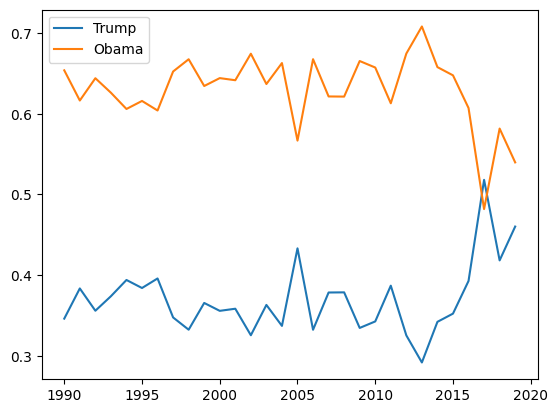

In [18]:
template = 'President [MASK] made a speech today'
years, fill_probs = l_fills(template, ['Trump', 'Obama'], model, tokenizer)
plt.figure()
plt.plot(years, [e[0] for e in fill_probs], label='Trump')
plt.plot(years, [e[1] for e in fill_probs], label='Obama')
plt.legend()
plt.show()